In [ ]:
import torch
import numpy as np
from torch import nn 
import random
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
imiona = open("imionapl.txt", encoding = "UTF-8").read().splitlines()
imiona = [i.lower() for i in imiona]
imiona[:5]

['ada', 'adalbert', 'adam', 'adela', 'adelajda']

In [ ]:
chars = sorted(list(set(''.join(imiona))))
stoi = {s:i +1  for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i :s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

31


In [ ]:
block_size = 3 
def build_dataset(imiona):  
    X, Y = [], []
    for w in imiona:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
random.seed(42)
random.shuffle(imiona)
n1 = int(0.8*len(imiona))
n2 = int(0.9*len(imiona))

X_train, Y_train = build_dataset(imiona[:n1])
X_dev, Y_dev = build_dataset(imiona[n1:n2])
X_test, Y_test = build_dataset(imiona[n2:])
    

torch.Size([3919, 3]) torch.Size([3919])
torch.Size([510, 3]) torch.Size([510])
torch.Size([480, 3]) torch.Size([480])


In [ ]:
class Linear:
    def __init__(self, ins, outs, bias = True):
        self.weight = torch.rand((ins,outs), generator = g)
        self.bias = torch.zeros((outs)) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []    
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.momentum = momentum 
        self.eps = eps
        self.training = True
        #
        self.gamma = torch.ones((dim))
        self.beta = torch.zeros((dim))
        #
        self.rmean = torch.zeros((dim))
        self.rvar = torch.ones((dim))
        
    def __call__(self, x):
            
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.rmean
            xvar = self.rvar
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.rmean = (1 - self.momentum) * self.rmean + self.momentum * xmean
                self.rvar = (1 - self.momentum) * self.rvar + self.momentum * xvar

        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
dims = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, dims),            generator=g)
layers = [
Linear(dims * block_size, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, vocab_size),
 ]



In [ ]:
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # applying gain 
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            
            layer.weight *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

      0/   2000: 3.4463


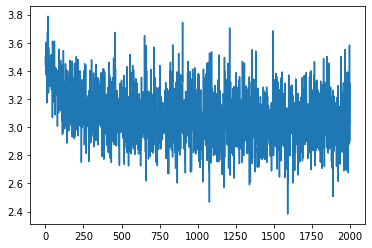

In [ ]:
# same optimization as last time
steps = 2000
batch_size = 32
losses = []
ud = []

for i in range(steps):
    # mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator = g)
    xb, yb = X_train[ix], Y_train[ix]
    emb = C[xb]
    x = emb.view(emb.shape[0], -1)
    
    #forward
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, yb)
    
    #backward
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{steps:7d}: {loss.item():.4f}')
    losses.append(loss.item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 2000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

        
plt.plot(np.arange(steps), losses);